In [1]:
import os
import pandas as pd
import matplotlib
import matplotlib.patches as mpatches
import matplotlib.pyplot as plt
import pickle
import string

from bisect import bisect_left, bisect_right
from collections import Counter, defaultdict
from datasets import Dataset, load_dataset, load_from_disk
from tqdm import tqdm

In [2]:
pd.set_option("display.max_rows", 500)

In [3]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [5]:
HUGGINGFACE_TOKEN = os.environ.get("HUGGINGFACE_TOKEN")

In [86]:
def get_pairs(byterange):
    """
    Returns pairs generated by
    https://github.com/google-research/deduplicate-text-datasets#collecting-the-duplicates-together
    """
    pairs = []
    with open(byterange, "r") as f:
        save = False
        for line in f:
            if line.strip() == "out":
                save = True
                continue
            if save:
                left, right = line.strip().split()
                pairs.append((int(left), int(right)))
    print("num pairs", len(pairs))
    return pairs

In [87]:
def get_bytes(pairs, data, offset=0):
    """
    Return bytes constituring the duplicated substring. There seems to be something off here, see:
    https://github.com/google-research/deduplicate-text-datasets/issues/24
    """
    byte_array = []
    for left, right in pairs:
        if left + offset >= right - offset:
            raise ValueError
        byte_array.append(data[left + offset : right - offset])

    print("byte_array size", len(byte_array))
    return byte_array

In [88]:
def get_doc_id(pos, pos2id):
    """
    Gets id of the datapoint at position.
    """
    pos2id_list = sorted(pos2id.keys())
    pos = bisect_right(pos2id_list, pos)
    doc_id = pos2id[pos2id_list[pos - 1]]
    return doc_id

In [89]:
def get_occurances(query, data_path):
    if isinstance(query, str):
        query = query.encode("utf-8")
    open("/tmp/fin", "wb").write(query)
    found = []
    out = os.popen(
        """/home/piktus_huggingface_co/lumi/deduplicate-text-datasets/target/debug/dedup_dataset count-occurrences \
            --data-file {} --query-file /tmp/fin""".format(
            data_path
        )
    ).read()
    lines = out.split("\n")
    for line in lines:
        if line.startswith("Found at: "):
            pos = int(line[len("Found at: ") :].strip())
            found.append(pos)

    total = int(out.strip().split("\n")[-1].split(" ")[-1])
    return found, total

In [90]:
def get_url(row, dataset_name):
    if dataset_name == "oscar":
        return row["meta"]["warc_headers"]["warc-target-uri"]
    if dataset_name == "the_pile" or dataset_name == "roots_en":
        return None
    return None

In [91]:
def get_cluster(row, repetitions):
    return [set(repetitions[rep]) for rep in row["repetitions"]]

In [120]:
non_printable = list(range(0, 32)) + [255]  # + list(range(127, 160))


def add_duplication_info(df_ds, dataset_name, byterange, data, pos2id, data_path, offset=0):
    pairs = get_pairs(byterange)
    byte_array = get_bytes(pairs, data, offset)

    doc_pairs = defaultdict(list)
    doc_bytes = defaultdict(list)
    dup_ratios = defaultdict(float)
    repetitions = defaultdict(list)

    for (l, r), b in zip(pairs, byte_array):
        i = get_doc_id(l, pos2id)
        doc_pairs[i].append((l, r))
        doc_bytes[i].append(b)
        repetitions[b].append(i)

    for i, pairs in doc_pairs.items():
        doc_len = len(df_ds.iloc[i]["text"])
        dup_len = sum([r - l for l, r in pairs])
        dup_ratio = (10000 * (dup_len / doc_len)) // 100
        dup_ratios[i] = dup_ratio

    print("repetitions", len(repetitions))

    if dataset_name != "c4":
        df_ds["url"] = df_ds.apply(lambda row: get_url(row, dataset_name), axis=1)
    df_ds["domain"] = df_ds.apply(lambda row: row["url"].split("/")[2] if row["url"] is not None else None, axis=1)
    df_ds["perplexity"] = df_ds.apply(lambda row: row["meta"]["perplexity_score"], axis=1)
    df_ds["dup_ratio"] = [dup_ratios[i] for i in range(len(df_ds))]
    df_ds["pairs"] = [doc_pairs[i] for i in range(len(df_ds))]
    df_ds["repetitions"] = [doc_bytes[i] for i in range(len(df_ds))]
    df_ds["cluster"] = df_ds.apply(lambda row: get_cluster(row, repetitions), axis=1)

    df_ds = df_ds.drop(["meta"], axis=1)

    unique_bytes = list(repetitions.keys())
    repetitions_df = pd.DataFrame.from_dict(
        {
            "repetition": unique_bytes,
            "ids": [repetitions[b] for b in unique_bytes],
            "num_docs": [len(repetitions[b]) for b in unique_bytes],
        }
    )
    return df_ds, repetitions_df

In [121]:
def get_dfs(dataset_name, base_dir="/mnt/disks/looking_glass_storage/lumi/dedup/"):
    data_path = base_dir + "/small-{ds}/small-{ds}.train".format(ds=dataset_name)
    byterange = base_dir + "/small-{ds}/small-{ds}.train.byterange".format(ds=dataset_name)
    data = open(data_path, "rb").read()
    pos2id = pickle.load(open(base_dir + "/small-{ds}/small-{ds}.train.pos2id.pkl".format(ds=dataset_name), "rb"))
    ds_df = pd.DataFrame(
        load_from_disk("/mnt/disks/looking_glass_storage/lumi/preprocessed_data/small-{}".format(dataset_name))[
            "train"
        ]
    )
    ds_df, repetitions_df = add_duplication_info(ds_df, dataset_name, byterange, data, pos2id, data_path)
    return ds_df, repetitions_df

In [122]:
def get_combined_df(dataset_names):
    datasets = {}
    repretitions = {}

    for name in dataset_names:
        print(name)
        ds_df, repetitions_df = get_dfs(name)
        datasets[name] = ds_df
        repretitions[name] = repetitions_df

    for name in dataset_names:
        datasets[name]["dataset"] = [name] * len(datasets[name])
        repretitions[name]["dataset"] = [name] * len(repretitions[name])

    datasets_df = pd.concat(datasets.values(), ignore_index=True)
    repretitions_df = pd.concat(repretitions.values(), ignore_index=True)
    return datasets_df, repretitions_df

In [123]:
# datasets_df, repretitions_df = get_combined_df(["roots_en", "the_pile", "oscar", "c4"])
# datasets_df.to_csv("/mnt/disks/looking_glass_storage/lumi/dedup/datasets_pandas.csv")
# repretitions_df.to_csv("/mnt/disks/looking_glass_storage/lumi/dedup/repetitions_pandas.csv")

In [124]:
# datasaet_names = ["oscar", "c4", "the_pile", "roots_en"]
datasaet_names = ["oscar"]
datasets = {}
repretitions = {}

for name in datasaet_names:
    print(name)
    ds_df, repetitions_df = get_dfs(name)
    datasets[name] = ds_df
    repretitions[name] = repetitions_df

oscar
num pairs 214884
byte_array size 214884
repetitions 166667


In [107]:
bytes_data = b"... Read article \xe2\x9e\x9d Oct 00, 0000 0 min read 000 0 "
"".join(map(chr, bytes_data))

'... Read article â\x9e\x9d Oct 00, 0000 0 min read 000 0 '

In [108]:
bytes_data.decode("latin-1")

'... Read article â\x9e\x9d Oct 00, 0000 0 min read 000 0 '

In [109]:
bytes_data.decode("utf-8")

'... Read article ➝ Oct 00, 0000 0 min read 000 0 '

In [125]:
datasets["oscar"]

,id,text,url,domain,perplexity,dup_ratio,pairs,repetitions,cluster
0,0,"Founded in 0000, Golden Bees is a leading prog...",http://www.ecap-partner.com/transactions/golde...,www.ecap-partner.com,286.0,0.0,[],[],[]
1,10000,Featuring a double strap (handles and cross-bo...,https://telfarshoppingbags.com/product/telfar-...,telfarshoppingbags.com,708.2,0.0,[],[],[]
2,20000,"The dictionary defines influence as: ""to have ...",http://www.hashtagtheology.com/2011/05/influen...,www.hashtagtheology.com,245.8,11.0,"[(15649, 15743), (15798, 16014)]",[b's at 0:00 AM Email ThisBlogThis!Share to Tw...,"[{2}, {2}]"
3,30000,"""There is a thirst and an appetite from intern...",https://tbivision.com/2014/11/24/show-week-far...,tbivision.com,542.9,28.0,"[(19527, 19610), (19617, 20924)]","[b"" FEATURES view all TBI Weekly: Exploring a ...","[{3785, 3}, {3785, 3}]"
4,40000,Let this be known: I cannot stand running. I r...,https://ymaa.com/articles?f%5B0%5D=field_date_...,ymaa.com,417.1,23.0,"[(21508, 21685)]",[b'. FULL 00 DAY TRIAL GUARANTEE If you are no...,"[{4, 4415}]"
...,...,...,...,...,...,...,...,...,...
43195,8858755,Spiderwort. There are many varieties of Spider...,https://bigjims.co.nz/tradescanthia-assorted-1...,bigjims.co.nz,322.6,0.0,[],[],[]
43196,8868755,Hypoxic-ischemic encephalopathy (HIE) is a typ...,https://www.abclawcenters.com/practice-areas/t...,www.abclawcenters.com,403.4,11.0,"[(246721444, 246721498), (246721710, 246721996...",[b' Medical Center Patient Safety Organization...,"[{43196}, {43196}, {43196}, {43196}, {43196}, ..."
43197,8878755,Blog writing has actually become one of the ma...,http://www.br28legionpipeband.com/2021/11/03/e...,www.br28legionpipeband.com,356.7,0.0,[],[],[]
43198,8888755,What are ilani's hours of operation? ilani is ...,https://stickinthemudpodcast.com/betting/can-y...,stickinthemudpodcast.com,567.2,11.0,"[(246737887, 246738213)]",[b'e money. About us Contact Privacy Policy & ...,"[{38884, 43198}]"


In [126]:
for name, df in datasets.items():
    print(name)
    ds = Dataset.from_pandas(df)
    ds.push_to_hub("ola13/small-{}-dedup".format(name), private=False, token=os.environ.get("HUGGINGFACE_TOKEN"))

oscar


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Updating downloaded metadata with the new split.


In [127]:
repretitions["oscar"].sort_values("num_docs", ascending=False).reset_index()

,index,repetition,ids,num_docs
0,1619,b'\x00\x00The website from which you got to th...,"[486, 1220, 1290, 5668, 6096, 6170, 8668, 8828...",39
1,773,"b'\x00\x00Due to the COVID-00 virus outbreak, ...","[239, 1934, 2889, 3692, 4010, 5282, 6098, 6598...",38
2,2185,b'\x00\x00In order to login you must be regist...,"[636, 1481, 5801, 6354, 7891, 8689, 9832, 1035...",35
3,11012,"b'\x00\x00You may not have to, it is up to the...","[2730, 3969, 5089, 6387, 6735, 8845, 9840, 100...",34
4,25118,b'\x00\x00Enter the username or e-mail you use...,"[6272, 7177, 9083, 9318, 9734, 11385, 11745, 1...",34
...,...,...,...,...
166662,65049,b'! Contact me with news and offers from other...,[15481],1
166663,65048,b'\x00\x00TechRadar is supported by its audien...,[15481],1
166664,65047,b'\x00\x00It looks like your browser does not ...,[15478],1
166665,65043,b'ents Meta Log in Entries feed Comments feed ...,[15470],1


In [128]:
for name, df in repretitions.items():
    print(name)
    ds = Dataset.from_pandas(df)
    ds.push_to_hub(
        "ola13/small-{}-repetitions".format(name),
        private=False,
        token=os.environ.get("HUGGINGFACE_TOKEN"),
    )

oscar


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Updating downloaded metadata with the new split.


In [68]:
colors = ["blue", "green", "lime", "cyan"]


def plot_histogram(x, bins=10, xlim=None, ylim=25000, limit=None, xlabel="Value", datasets=None):
    plt.figure(figsize=(15, 5))
    legend_patches = []
    for i, (dataset_name, x) in enumerate(x.items()):
        n, bins, patches = plt.hist(x, bins, facecolor=colors[i], alpha=0.75)
        legend_patches.append(
            mpatches.Patch(
                color=colors[i],
                label="{} - {:.2f} overall duplicate ratio".format(
                    dataset_name,
                    (100 * len(datasets[dataset_name][datasets[dataset_name]["dup_ratio"] == 0.0]))
                    / len(datasets[dataset_name]),
                ),
            )
        )
        if limit is not None:
            ratio = (sum([1 for i in x if i >= limit]) * 100) / len(x)
            plt.axvline(x=limit, linewidth=0.5, color="red")
            plt.text(
                limit + 1.5,
                ylim * 0.3 + (i + 1) * 200,
                "Dups ratio >= {}.00 make {:.2f} total dups in {}.".format(limit, ratio, dataset_name),
            )

    if xlim is None:
        xlim = max(x) + 10
        print(max(x))
    plt.xlim(0, xlim)
    plt.ylim(0, ylim)

    plt.xlabel(xlabel)
    plt.ylabel("Count")
    plt.title("Histogram of {}s".format(xlabel))
    plt.legend(handles=legend_patches)

    plt.show()

In [38]:
def show_cluster(repetitions_df, df_ds, i):
    reps = repetitions_df.iloc[i]["repetition"]
    idxs = repetitions_df.iloc[i]["ids"]
    print(reps)
    print(idxs)
    print()

    for idx in idxs:
        print(df_ds.iloc[idx]["perplexity"])
        print(df_ds.iloc[idx]["text"])
        print()

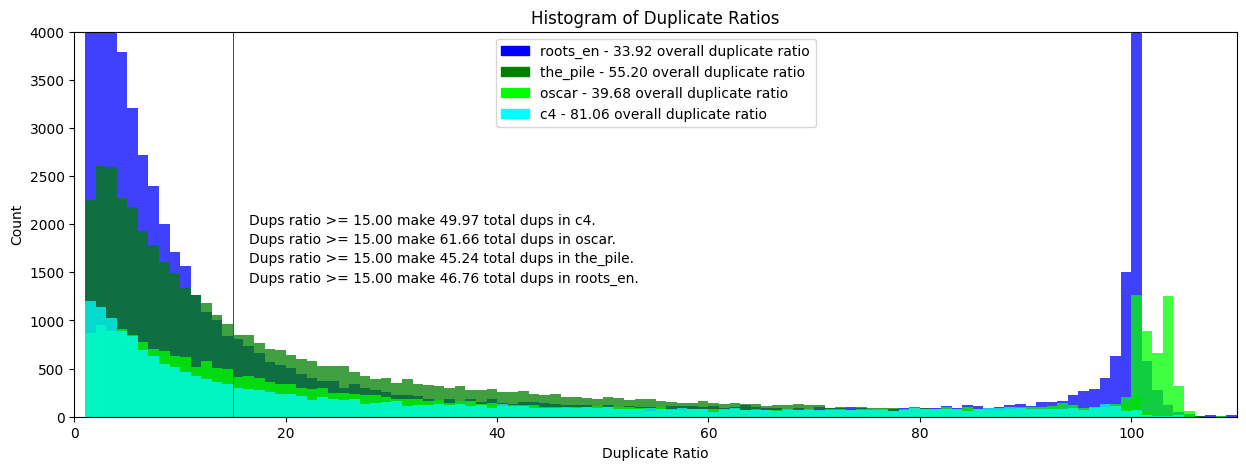

In [69]:
x = {}
dataset_names = ["roots_en", "the_pile", "oscar", "c4"]
for name in dataset_names:
    x[name] = datasets[name][datasets[name]["dup_ratio"] > 0.0]["dup_ratio"]

plot_histogram(
    x, bins=list(range(150)), xlim=110, ylim=4000, limit=15, xlabel="Duplicate Ratio", datasets=datasets
)

In [63]:
for name in dataset_names:
    print(name)
    display(datasets[name])
    display(repretitions[name])

roots_en


,text,url,domain,perplexity,dup_ratio,pairs,repetitions
0,I'm here to tell you about the real search for...,None,None,252.8,99.0,"[(4, 13180), (13183, 13628), (13633, 15375)]",[b'\x00\x00I\'m here to tell you about the rea...
1,Someone who looks like me walks past you in th...,None,None,240.3,0.0,"[(16636, 16689), (21988, 22041)]","[b' lack of diversity in our workforce, partic..."
2,I've learned some of my most important life le...,None,None,186.3,0.0,[],[]
3,So if I told you that this was the face of pur...,None,None,268.1,0.0,[],[]
4,Why do we cheat? And why do happy people cheat...,None,None,290.5,0.0,[],[]
...,...,...,...,...,...,...,...
99995,Q: How to contact professors as a high school...,None,None,228.5,0.0,[],[]
99996,Q: Would summarizing peer-reviewed articles o...,None,None,351.3,0.0,[],[]
99997,Q: Will experience in related fields help me ...,None,None,339.7,0.0,[],[]
99998,Q: Should I do someone else's peer-review wor...,None,None,283.3,0.0,[],[]


,repetition,ids,num_docs
0,b'\x00\x00I\'m here to tell you about the real...,"[0, 2102]",2
1,"b"" the second generation, we will have the cap...","[0, 2102]",2
2,"b"" that actually might be inhabitable by human...","[0, 2102]",2
3,"b' lack of diversity in our workforce, particu...","[1, 1]",2
4,"b""ty right is the kind of right to which you'r...","[5, 5]",2
...,...,...,...
586251,b' researcher digital identification services ...,"[99984, 99984]",2
586252,b' Is it impolite to suggest that he book a do...,[99994],1
586253,b'ch the visit for an extra weekend after the ...,"[99994, 99994]",2
586254,b' Is it impolite to suggest that he book a do...,[99994],1


the_pile


,text,url,domain,perplexity,dup_ratio,pairs,repetitions
0,"It is done, and submitted. You can play ""Survi...",None,None,294.3,1.0,"[(12691, 12844)]",[b'0. You can follow any responses to this ent...
1,"<?xml version=""0.0"" encoding=""UTF-0""?> <segme...",None,None,978.4,90.0,"[(13437, 13549), (13559, 13739), (13750, 13939...","[b'> <field minOccurs=""0"" maxOccurs=""..."
2,Article content Human behavior has a tremendo...,None,None,513.4,10.0,"[(17831, 17961)]","[b' We apologize, but this video has failed t..."
3,Topic: reinvent midnight madness Amazon annou...,None,None,264.7,0.0,[],[]
4,About Grand Slam Fishing Charters As a family...,None,None,736.8,0.0,[],[]
...,...,...,...,...,...,...,...
99995,00000 and -0.0? 00000.0 What is the distance b...,None,None,3510.2,3.0,"[(602217282, 602217334), (602221763, 602221815...",[b'000 What is the difference between 0.00000 ...
99996,Beautiful Beautiful Beads like these glass pea...,None,None,595.1,0.0,[],[]
99997,NOT FOR PUBLICATION WITHOUT THE ...,None,None,305.0,11.0,"[(602226427, 602227008), (602227638, 602227697...",[b'\x01\x00NOT FOR PUBLICATION WITHOUT THE ...
99998,Radio transmitters and receivers require filte...,None,None,313.2,3.0,"[(602248567, 602248624), (602248709, 602248766...",[b' separation between the transmit and receiv...


,repetition,ids,num_docs
0,b'0. You can follow any responses to this entr...,[0],1
1,"b'> <field minOccurs=""0"" maxOccurs=""0...",[1],1
2,b'</description> <datatype>IS</da...,"[1, 1]",2
3,b'</description> <datatype>IS</da...,[1],1
4,b'</description> <datatype>XON</d...,[1],1
...,...,...,...
471327,b'al. ...,[99997],1
471328,b' Affirmed. ...,[99997],1
471329,b' separation between the transmit and receive...,"[99998, 99998]",2
471330,"b' Japanese Patent Application No. 00000000, P...","[99998, 99998]",2


oscar


,id,text,url,domain,perplexity,dup_ratio,pairs,repetitions
0,0,"Founded in 0000, Golden Bees is a leading prog...",http://www.ecap-partner.com/transactions/golde...,www.ecap-partner.com,286.0,0.0,[],[]
1,10000,Featuring a double strap (handles and cross-bo...,https://telfarshoppingbags.com/product/telfar-...,telfarshoppingbags.com,708.2,0.0,[],[]
2,20000,"The dictionary defines influence as: ""to have ...",http://www.hashtagtheology.com/2011/05/influen...,www.hashtagtheology.com,245.8,11.0,"[(15649, 15743), (15798, 16014)]",[b's at 0:00 AM Email ThisBlogThis!Share to Tw...
3,30000,"""There is a thirst and an appetite from intern...",https://tbivision.com/2014/11/24/show-week-far...,tbivision.com,542.9,28.0,"[(19527, 19610), (19617, 20924)]","[b"" FEATURES view all TBI Weekly: Exploring a ..."
4,40000,Let this be known: I cannot stand running. I r...,https://ymaa.com/articles?f%5B0%5D=field_date_...,ymaa.com,417.1,23.0,"[(21508, 21685)]",[b'. FULL 00 DAY TRIAL GUARANTEE If you are no...
...,...,...,...,...,...,...,...,...
43195,8858755,Spiderwort. There are many varieties of Spider...,https://bigjims.co.nz/tradescanthia-assorted-1...,bigjims.co.nz,322.6,0.0,[],[]
43196,8868755,Hypoxic-ischemic encephalopathy (HIE) is a typ...,https://www.abclawcenters.com/practice-areas/t...,www.abclawcenters.com,403.4,11.0,"[(246721444, 246721498), (246721710, 246721996...",[b' Medical Center Patient Safety Organization...
43197,8878755,Blog writing has actually become one of the ma...,http://www.br28legionpipeband.com/2021/11/03/e...,www.br28legionpipeband.com,356.7,0.0,[],[]
43198,8888755,What are ilani's hours of operation? ilani is ...,https://stickinthemudpodcast.com/betting/can-y...,stickinthemudpodcast.com,567.2,11.0,"[(246737887, 246738213)]",[b'e money. About us Contact Privacy Policy & ...


,repetition,ids,num_docs
0,b's at 0:00 AM Email ThisBlogThis!Share to Twi...,[2],1
1,b' No comments: Post a Comment Newer Post Olde...,[2],1
2,"b"" FEATURES view all TBI Weekly: Exploring a n...","[3, 3785]",2
3,b' ago TBI Tech & Analysis: Unpacking Netflix ...,"[3, 3785]",2
4,b'. FULL 00 DAY TRIAL GUARANTEE If you are not...,"[4, 4415]",2
...,...,...,...
166662,"b'Stock market news, Trading, investing, long ...",[43199],1
166663,b' [link] [comments] @AlphaexCapital : Do you ...,[43199],1
166664,"b"". Forex is the foreign exchange market, trad...",[43199],1
166665,b'] [0000] [000] [000] [000] [0000] [0000] [00...,[43199],1


c4


,text,timestamp,url,domain,perplexity,dup_ratio,pairs,repetitions
0,Beginners BBQ Class Taking Place in Missoula! ...,2019-04-25T12:57:54Z,https://klyq.com/beginners-bbq-class-taking-pl...,klyq.com,390.6,0.0,[],[]
1,Discussion in 'Mac OS X Lion (00.0)' started b...,2019-04-21T10:07:13Z,https://forums.macrumors.com/threads/restore-f...,forums.macrumors.com,659.4,0.0,[],[]
2,Foil plaid lycra and spandex shortall with met...,2019-04-25T10:40:23Z,https://awishcometrue.com/Catalogs/Clearance/T...,awishcometrue.com,540.6,0.0,[],[]
3,How many backlinks per day for new site? Discu...,2019-04-21T12:46:19Z,https://www.blackhatworld.com/seo/how-many-bac...,www.blackhatworld.com,784.1,0.0,[],[]
4,The Denver Board of Education opened the 0000-...,2019-04-20T14:33:21Z,http://bond.dpsk12.org/category/news/,bond.dpsk12.org,459.9,0.0,[],[]
...,...,...,...,...,...,...,...,...
99995,"Today designer, Joann is sharing an adorable b...",2019-04-19T06:27:50Z,https://thecraftypickle.com/2015/01/08/happy-b...,thecraftypickle.com,671.0,0.0,[],[]
99996,Despite conflicts and political developments b...,2019-04-18T21:01:36Z,https://www.aaiusa.org/w030606,www.aaiusa.org,202.7,0.0,[],[]
99997,Is there a better alternative to Woobies? Is W...,2019-04-18T12:58:50Z,https://www.macupdate.com/app/mac/51667/woobies,www.macupdate.com,2624.4,33.0,"[(216284899, 216284980), (216284987, 216285067)]",[b' needs a review. Be the first to review thi...
99998,What Is FUE Hair Transplantation Technique? Fo...,2019-04-25T06:25:49Z,https://www.emrahcinik.com/fue-hair-transplant...,www.emrahcinik.com,382.0,0.0,[],[]


,repetition,ids,num_docs
0,"b' train timings, routes, stops, and complete ...",[5],1
1,b'n from BANGALORE CY JUNCTION (YPR) to GONDIA...,[5],1
2,b' EXP (00000) that departs at 00:00 and arriv...,"[5, 59410]",2
3,"b'he National Baseball Hall of Fame,"" (with Cl...","[12, 12]",2
4,"b' The colorless, transparent variety of Quart...","[19, 19]",2
...,...,...,...
62337,"b'! All of the participants - performers, prac...",[99994],1
62338,b' cause. This is an incredible group who have...,"[99994, 99994]",2
62339,"b' All of the participants - performers, pract...",[99994],1
62340,"b'! All of the participants - performers, prac...",[99994],1


In [35]:
for k, v in datasets.items():
    print(k, v.shape, "Num dups:", len(v[v["dup_ratio"] > 0.0]))
    display(
        v[v["dup_ratio"] > 0.0]
        .groupby(["domain"])
        .size()
        .reset_index(name="counts")
        .sort_values("counts", ascending=False),
    )

    display(
        v[v["dup_ratio"] == 0.0]
        .groupby(["domain"])
        .size()
        .reset_index(name="counts")
        .sort_values("counts", ascending=False),
    )

c4 (100000, 8) Num dups: 18938


,domain,counts
2579,en.wikipedia.org,33
2204,do5.b00kmedia.ru,33
5862,patents.google.com,29
2564,en.m.wikipedia.org,15
10645,www.encyclopedia.com,14
...,...,...
5645,oldleandude.com,1
5646,oldsmarconnect.com,1
5647,oldtestamentpassion.blogspot.com,1
5648,oldwineglasses.com,1


,domain,counts
51257,www.huffpost.com,34
59041,www.nytimes.com,29
54254,www.latimes.com,28
44151,www.dailymail.co.uk,28
67509,www.theguardian.com,27
...,...,...
24899,philharmoniasings.us3.list-manage.com,1
24900,philhemsley.wordpress.com,1
24901,philhulettandfriends.com,1
24902,philipbeesleyarchitect.com,1


oscar (43200, 8) Num dups: 26058


,domain,counts
3612,docs.google.com,10
9747,pubmed.ncbi.nlm.nih.gov,10
11869,thenextweb.com,9
4042,en.wikipedia.org,8
14999,www.cnbc.com,8
...,...,...
7893,mcclanahanacademy.com,1
7892,mbicorp.ca,1
7891,maziebones.com,1
7890,mayumipublishing.com,1


,domain,counts
8012,techcrunch.com,8
13634,www.nordstrom.com,7
3510,gizmodo.com,7
1015,biography.omicsonline.org,6
11672,www.ghanaweb.com,6
...,...,...
5607,mythbreaker.co.uk,1
5608,mythoscreativewriting.com,1
5609,myvideogamelist.com,1
5610,mywikibiz.com,1


the_pile (100000, 7) Num dups: 44798


,domain,counts


,domain,counts


roots_en (100000, 7) Num dups: 66077


,domain,counts


,domain,counts


In [ ]:
repetitions_df.sort_values("num_docs", ascending=False).reset_index()

In [ ]:
df_ds[df_ds["dup_ratio"] > 0.0]

In [40]:
show_cluster(repretitions["the_pile"], datasets["the_pile"], 2)

b'</description>              <datatype>IS</datatype>          </field>          <field minOccurs="0" maxOccurs="0">              <name>PD0.0</name>              <description>Living '
[1, 1]

978.4
<?xml version="0.0" encoding="UTF-0"?>  <segment>      <name>PD0</name>      <description>Patient Additional Demographic</description>      <elements>          <field minOccurs="0" maxOccurs="0">              <name>PD0.0</name>              <description>Living Dependency</description>              <datatype>IS</datatype>          </field>          <field minOccurs="0" maxOccurs="0">              <name>PD0.0</name>              <description>Living Arrangement</description>              <datatype>IS</datatype>          </field>          <field minOccurs="0" maxOccurs="0">              <name>PD0.0</name>              <description>Patient Primary Facility</description>              <datatype>XON</datatype>          </field>          <field minOccurs="0" maxOccurs="0">              <name>PD0.0</n

In [ ]:
df_ds[df_ds["dup_ratio"] > 100.0].iloc[5]["text"]

In [ ]:
plot_cluster_histogram(repetitions_df)

In [ ]:
df_ds.sort_values("dup_ratio", ascending=False)

In [ ]:
df_ds.sort_values("perplexity", ascending=False)[:100]

In [ ]:
ds_df = pd.DataFrame(
    load_from_disk("/mnt/disks/looking_glass_storage/lumi/preprocessed_data/small-{}".format("the_pile"))["train"]
)

In [ ]:
ds_df.iloc[0]["meta"]

In [3]:
df = pd.read_csv("/mnt/disks/looking_glass_storage/lumi/dedup/pandas_datasets.csv")

/tmp/ipykernel_41745/3932202117.py:1: DtypeWarning: Columns (2,3,10) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("/mnt/disks/looking_glass_storage/lumi/dedup/pandas_datasets.csv")


In [4]:
df

,Unnamed: 0,text,url,domain,perplexity,dup_ratio,pairs,repetitions,dataset,id,timestamp
0,0,I'm here to tell you about the real search for...,NaN,NaN,252.8,99.0,"[(4, 13180), (13183, 13628), (13633, 15375)]",[b'\x00\x00I\'m here to tell you about the rea...,roots_en,NaN,NaN
1,1,Someone who looks like me walks past you in th...,NaN,NaN,240.3,0.0,"[(16636, 16689), (21988, 22041)]","[b' lack of diversity in our workforce, partic...",roots_en,NaN,NaN
2,2,I've learned some of my most important life le...,NaN,NaN,186.3,0.0,[],[],roots_en,NaN,NaN
3,3,So if I told you that this was the face of pur...,NaN,NaN,268.1,0.0,[],[],roots_en,NaN,NaN
4,4,Why do we cheat? And why do happy people cheat...,NaN,NaN,290.5,0.0,[],[],roots_en,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...
343195,343195,"Today designer, Joann is sharing an adorable b...",https://thecraftypickle.com/2015/01/08/happy-b...,thecraftypickle.com,671.0,0.0,[],[],c4,NaN,2019-04-19T06:27:50Z
343196,343196,Despite conflicts and political developments b...,https://www.aaiusa.org/w030606,www.aaiusa.org,202.7,0.0,[],[],c4,NaN,2019-04-18T21:01:36Z
343197,343197,Is there a better alternative to Woobies? Is W...,https://www.macupdate.com/app/mac/51667/woobies,www.macupdate.com,2624.4,33.0,"[(216284899, 216284980), (216284987, 216285067)]",[b' needs a review. Be the first to review thi...,c4,NaN,2019-04-18T12:58:50Z
343198,343198,What Is FUE Hair Transplantation Technique? Fo...,https://www.emrahcinik.com/fue-hair-transplant...,www.emrahcinik.com,382.0,0.0,[],[],c4,NaN,2019-04-25T06:25:49Z


In [5]:
df[df["dataset"] == "oscar"]

,Unnamed: 0,text,url,domain,perplexity,dup_ratio,pairs,repetitions,dataset,id,timestamp
200000,200000,"Founded in 0000, Golden Bees is a leading prog...",http://www.ecap-partner.com/transactions/golde...,www.ecap-partner.com,286.0,0.0,[],[],oscar,0.0,NaN
200001,200001,Featuring a double strap (handles and cross-bo...,https://telfarshoppingbags.com/product/telfar-...,telfarshoppingbags.com,708.2,0.0,[],[],oscar,10000.0,NaN
200002,200002,"The dictionary defines influence as: ""to have ...",http://www.hashtagtheology.com/2011/05/influen...,www.hashtagtheology.com,245.8,11.0,"[(15649, 15743), (15798, 16014)]",[b's at 0:00 AM Email ThisBlogThis!Share to Tw...,oscar,20000.0,NaN
200003,200003,"""There is a thirst and an appetite from intern...",https://tbivision.com/2014/11/24/show-week-far...,tbivision.com,542.9,28.0,"[(19527, 19610), (19617, 20924)]","[b"" FEATURES view all TBI Weekly: Exploring a ...",oscar,30000.0,NaN
200004,200004,Let this be known: I cannot stand running. I r...,https://ymaa.com/articles?f%5B0%5D=field_date_...,ymaa.com,417.1,23.0,"[(21508, 21685)]",[b'. FULL 00 DAY TRIAL GUARANTEE If you are no...,oscar,40000.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
243195,243195,Spiderwort. There are many varieties of Spider...,https://bigjims.co.nz/tradescanthia-assorted-1...,bigjims.co.nz,322.6,0.0,[],[],oscar,8858755.0,NaN
243196,243196,Hypoxic-ischemic encephalopathy (HIE) is a typ...,https://www.abclawcenters.com/practice-areas/t...,www.abclawcenters.com,403.4,11.0,"[(246721444, 246721498), (246721710, 246721996...",[b' Medical Center Patient Safety Organization...,oscar,8868755.0,NaN
243197,243197,Blog writing has actually become one of the ma...,http://www.br28legionpipeband.com/2021/11/03/e...,www.br28legionpipeband.com,356.7,0.0,[],[],oscar,8878755.0,NaN
243198,243198,What are ilani's hours of operation? ilani is ...,https://stickinthemudpodcast.com/betting/can-y...,stickinthemudpodcast.com,567.2,11.0,"[(246737887, 246738213)]",[b'e money. About us Contact Privacy Policy & ...,oscar,8888755.0,NaN


In [177]:
near_dup_ds = load_from_disk("/mnt/disks/looking_glass_storage/lumi/near_dedup/")

In [178]:
near_dedup_df = pd.DataFrame(near_dup_ds)

In [179]:
near_dedup_df

,id,text,url,domain,perplexity,dup_ratio,pairs,repetitions,cluster,near_dup,near_dup_cluster
0,0,"Founded in 0000, Golden Bees is a leading prog...",http://www.ecap-partner.com/transactions/golde...,www.ecap-partner.com,286.0,0.0,[],[],[],False,[]
1,10000,Featuring a double strap (handles and cross-bo...,https://telfarshoppingbags.com/product/telfar-...,telfarshoppingbags.com,708.2,0.0,[],[],[],False,[]
2,20000,"The dictionary defines influence as: ""to have ...",http://www.hashtagtheology.com/2011/05/influen...,www.hashtagtheology.com,245.8,11.0,"[[15649, 15743], [15798, 16014]]",[b's at 0:00 AM Email ThisBlogThis!Share to Tw...,"[[2], [2]]",False,[]
3,30000,"""There is a thirst and an appetite from intern...",https://tbivision.com/2014/11/24/show-week-far...,tbivision.com,542.9,28.0,"[[19527, 19610], [19617, 20924]]","[b"" FEATURES view all TBI Weekly: Exploring a ...","[[3785, 3], [3785, 3]]",False,[]
4,40000,Let this be known: I cannot stand running. I r...,https://ymaa.com/articles?f%5B0%5D=field_date_...,ymaa.com,417.1,23.0,"[[21508, 21685]]",[b'. FULL 00 DAY TRIAL GUARANTEE If you are no...,"[[4, 4415]]",False,[]
...,...,...,...,...,...,...,...,...,...,...,...
43195,8858755,Spiderwort. There are many varieties of Spider...,https://bigjims.co.nz/tradescanthia-assorted-1...,bigjims.co.nz,322.6,0.0,[],[],[],False,[]
43196,8868755,Hypoxic-ischemic encephalopathy (HIE) is a typ...,https://www.abclawcenters.com/practice-areas/t...,www.abclawcenters.com,403.4,11.0,"[[246721444, 246721498], [246721710, 246721996...",[b' Medical Center Patient Safety Organization...,"[[43196], [43196], [43196], [43196], [43196], ...",False,[]
43197,8878755,Blog writing has actually become one of the ma...,http://www.br28legionpipeband.com/2021/11/03/e...,www.br28legionpipeband.com,356.7,0.0,[],[],[],False,[]
43198,8888755,What are ilani's hours of operation? ilani is ...,https://stickinthemudpodcast.com/betting/can-y...,stickinthemudpodcast.com,567.2,11.0,"[[246737887, 246738213]]",[b'e money. About us Contact Privacy Policy & ...,"[[38884, 43198]]",False,[]


In [180]:
def view_near_dedup_cluster(ds, i):
    datapoint = ds.iloc[i]
    near_dup_cluster = datapoint["near_dup_cluster"]
    print(datapoint["text"])
    print(datapoint["dup_ratio"])
    print()
    for i in near_dup_cluster:
        print(i, ds.iloc[i]["text"])

In [181]:
view_near_dedup_cluster(near_dedup_df, 43151)

Browse and search an inventory of the Austin History Center's archival collections. Where appropriate, click on the collection title to view the collection finding aid (a detailed description of the collection) hosted by Texas Archival Resources Online. These links will open the description in a new browser window. To access the collections you must visit the Austin History Center. If a finding aid is not available online, you are unable to find what you are searching for or access is listed "Advanced notice required" or "Some portions may require advance notice" contact AHC staff for more information. Contact Us by mail or by phone: 000-000-0000.
100.0

6880 Browse and search an inventory of the Austin History Center's archival collections. Where appropriate, click on the collection title to view the collection finding aid (a detailed description of the collection) hosted by Texas Archival Resources Online. These links will open the description in a new browser window. To access the c

In [182]:
view_near_dedup_cluster(near_dedup_df, 37357)

If this is your first visit, be sure to check out the FAQ by clicking the link above. You may have to register before you can post: click the register link above to proceed. To start viewing messages, select the forum that you want to visit from the selection below.
0.0

3329 If this is your first visit, be sure to check out the FAQ by clicking the link above. You may have to register before you can post: click the register link above to proceed. To start viewing messages, select the forum that you want to visit from the selection below.
5635 If this is your first visit, be sure to check out the FAQ by clicking the link above. You may have to register before you can post: click the register link above to proceed. To start viewing messages, select the forum that you want to visit from the selection below.
42627 If this is your first visit, be sure to check out the FAQ by clicking the link above. You may have to register before you can post: click the register link above to proceed. To s

In [183]:
near_only = near_dedup_df[(near_dedup_df["near_dup"] == True) & (near_dedup_df["dup_ratio"] == 0.0)]
print(len(near_only))
print(sum([len(row["near_dup_cluster"]) for _, row in near_only.iterrows()]))
display(near_only)

18
1529


,id,text,url,domain,perplexity,dup_ratio,pairs,repetitions,cluster,near_dup,near_dup_cluster
599,5990000,"FeaturedBest sellingAlphabetically, A-ZAlphabe...",https://zainabscloset.com/collections/skirts-p...,zainabscloset.com,908.7,0.0,[],[],[],True,"[20107, 9499, 932, 42405, 13099, 12723, 697, 2..."
749,7490000,"Due to the COVID-00 virus outbreak, many of th...",https://events.keyt.com/default.aspx?ct=r&type...,events.keyt.com,149.1,0.0,[],[],[],True,"[17794, 25092, 24581, 20488, 33420, 1934, 1908..."
1342,4393326,"Except where otherwise noted, content on this ...",https://www.it.lut.fi/wiki/doku.php/start?tab_...,www.it.lut.fi,85.8,0.0,[],[],[],True,"[8716, 29199, 26140, 28190, 8224, 4647, 28223,..."
3322,6134195,"You may not have to, it is up to the administr...",https://www.bookup.com/forum/app.php/help/faq?...,www.bookup.com,515.4,0.0,[],[],[],True,"[12290, 36867, 24068, 37899, 28176, 38939, 338..."
10721,7851380,In order to login you must be registered. Regi...,https://www.hotrodcoffeeshop.com/forum/ucp.php...,www.hotrodcoffeeshop.com,851.0,0.0,[],[],[],True,"[29184, 41987, 11779, 20485, 38407, 34314, 462..."
15649,2893614,Privacy & Cookies: This site uses cookies. By ...,https://jobbiecrew.com/tag/amazing-pools/,jobbiecrew.com,387.2,0.0,[],[],[],True,"[26112, 13837, 12309, 26645, 35873, 30250, 413..."
22297,6100981,"Except where otherwise noted, content on this ...",https://helpdesk.strw.leidenuniv.nl/wiki/doku....,helpdesk.strw.leidenuniv.nl,144.1,0.0,[],[],[],True,"[8716, 29199, 26140, 28190, 8224, 4647, 28223,..."
23215,6216502,"If this is your first visit, be sure to check ...",http://forums.trovegame.com/member.php?7083486...,forums.trovegame.com,652.0,0.0,[],[],[],True,"[3329, 5635, 42627, 27397, 12166, 14470, 4743,..."
23454,8606502,"Except where otherwise noted, content on this ...",https://wiki.oxwall.com/docs-faq-guide_for_beg...,wiki.oxwall.com,65.6,0.0,[],[],[],True,"[8716, 29199, 26140, 28190, 8224, 4647, 28223,..."
25560,2561030,We have found 00 Superman Emblem Clip Art imag...,https://www.cliparthut.com/superman-emblem-cli...,www.cliparthut.com,1106.0,0.0,[],[],[],True,"[25560, 7980]"


In [175]:
for i in near_only.iterrows():
    print(i)

(749, id                                                            7490000
text                Due to the COVID-00 virus outbreak, many of th...
url                 https://events.keyt.com/default.aspx?ct=r&type...
domain                                                events.keyt.com
perplexity                                                      149.1
dup_ratio                                                         0.0
pairs                                                              []
repetitions                                                        []
cluster                                                            []
near_dup                                                         True
near_dup_cluster    [17794, 25092, 24581, 20488, 33420, 1934, 1908...
Name: 749, dtype: object)
(1342, id                                                            4393326
text                Except where otherwise noted, content on this ...
url                 https://www.it.lut.fi/wiki/doku

In [150]:
near_dedup_df[(near_dedup_df["near_dup"] == True)]

,id,text,url,domain,perplexity,dup_ratio,pairs,repetitions,cluster,near_dup,near_dup_cluster
109,1090000,"You may not have to, it is up to the administr...",http://forums.lukpac.org/faq.php?sid=debcbcc3a...,forums.lukpac.org,516.3,100.0,"[[614223, 639075]]","[b'\x00\x00You may not have to, it is up to th...","[[3393, 15052, 109, 8302, 17490, 16085, 33821]]",True,"[12290, 36867, 24068, 37899, 28176, 38939, 338..."
147,1470000,In order to login you must be registered. Regi...,https://rj-texted.se/Forum/ucp.php?mode=login&...,rj-texted.se,851.0,101.0,"[[830425, 830797]]",[b'\x00\x00\x00In order to login you must be r...,"[[147, 247]]",True,"[29184, 41987, 11779, 20485, 38407, 34314, 462..."
162,1620000,In total there are 00 users online :: 0 regist...,https://forums.playtonicgames.com/index.php?si...,forums.playtonicgames.com,543.1,104.0,"[[901460, 901587]]",[b'\x00\x00In total there are 00 users online ...,"[[3490, 162]]",True,"[4235, 16017, 38674, 17683, 7831, 28825, 34845..."
166,1660000,JavaScript is disabled. For a better experienc...,https://www.focaljet.com/tags/subwoofers/,www.focaljet.com,2291.9,104.0,"[[904182, 904295]]",[b'\x00\x00\x00JavaScript is disabled. For a b...,[[166]],True,"[6660, 17938, 26643, 5659, 16926, 21027, 43044..."
239,2390000,"Due to the COVID-00 virus outbreak, many of th...",https://events.thv11.com/default.aspx?ct=r&typ...,events.thv11.com,149.1,103.0,"[[1491882, 1491992]]","[b'\x00\x00Due to the COVID-00 virus outbreak,...","[[17794, 25092, 24581, 33420, 1934, 33937, 135...",True,"[17794, 25092, 24581, 20488, 33420, 1934, 1908..."
...,...,...,...,...,...,...,...,...,...,...,...
43142,8328755,Unfortunately your browser isn't supported by ...,https://disa.webs.upv.es/mrbs2017/web/edit_ent...,disa.webs.upv.es,569.8,103.0,"[[246379799, 246379934]]","[b""\x00\x00Unfortunately your browser isn't su...","[[7267, 28612, 35749, 30758, 9959, 43142, 1927...",True,"[43142, 6164, 33045, 277, 8474, 1950, 35749, 3..."
43145,8358755,We use cookies to improve your experience on o...,https://shascreation.com/product-category/prem...,shascreation.com,611.7,103.0,"[[246382708, 246382828]]",[b'\x00\x00We use cookies to improve your expe...,"[[14689, 34753, 37988, 5673, 43145, 31479, 369...",True,"[34753, 14689, 37988, 43145, 5673, 31479, 3695..."
43151,8418755,Browse and search an inventory of the Austin H...,https://library.austintexas.gov/ahc/archives/h...,library.austintexas.gov,399.1,100.0,"[[246396228, 246396887]]",[b'\x00\x00Browse and search an inventory of t...,"[[6880, 32077, 43151]]",True,"[6880, 32077, 43151]"
43152,8428755,Place + in front of a word which must be found...,https://www.purplemartin.org/forum/search.php?...,www.purplemartin.org,731.8,100.0,"[[246396889, 246397413]]",[b'\x00\x00Place + in front of a word which mu...,"[[3136, 28358, 30182, 38119, 23019, 13230, 262...",True,"[3136, 28358, 30182, 38119, 23019, 26222, 1323..."


In [151]:
near_dedup_df[(near_dedup_df["dup_ratio"] == 0.0)]

,id,text,url,domain,perplexity,dup_ratio,pairs,repetitions,cluster,near_dup,near_dup_cluster
0,0,"Founded in 0000, Golden Bees is a leading prog...",http://www.ecap-partner.com/transactions/golde...,www.ecap-partner.com,286.0,0.0,[],[],[],False,[]
1,10000,Featuring a double strap (handles and cross-bo...,https://telfarshoppingbags.com/product/telfar-...,telfarshoppingbags.com,708.2,0.0,[],[],[],False,[]
6,60000,"Baden Joel S., ""The Continuity of the Non-Prie...",http://bsw.org/biblica/vol-93-2012/v1-2/,bsw.org,454.3,0.0,[],[],[],False,[]
8,80000,Chalk me up as one who didn't see this coming....,https://www.starkinsider.com/2020/08/amazon-ha...,www.starkinsider.com,556.7,0.0,[],[],[],False,[]
10,100000,The competition among wireless carriers has hi...,https://www.westhost.com/blog/unlimited-data-r...,www.westhost.com,316.3,0.0,[],[],[],False,[]
...,...,...,...,...,...,...,...,...,...,...,...
43187,8778755,ESSR offers a variety of online and classroom-...,https://irroc.umd.edu/id/99,irroc.umd.edu,274.8,0.0,[],[],[],False,[]
43188,8788755,Some designs will take longer to deliver than ...,https://www.neptune.com/dining/tableware/lulwo...,www.neptune.com,440.8,0.0,[],[],[],False,[]
43192,8828755,Student Activities and Organizations maintaine...,https://www.luther.edu/studentlife/activities/...,www.luther.edu,516.8,0.0,[],[],[],False,[]
43195,8858755,Spiderwort. There are many varieties of Spider...,https://bigjims.co.nz/tradescanthia-assorted-1...,bigjims.co.nz,322.6,0.0,[],[],[],False,[]


In [38]:
def get_max_len(dataset_name, base_dir="/home/piktus_huggingface_co/lumi/preprocessed_data/"):
    df = pd.DataFrame(load_from_disk(base_dir + dataset_name)["train"])
    df["text_length"] = df.apply(lambda doc: len(doc["text"]), axis=1)
    max_len = max(df["text_length"])
    print("max_len", max_len)
    idx = df.index[df["text_length"] == max_len].to_list()
    print("idx", idx)
    return df.iloc[idx[0]]["text"]

In [39]:
get_max_len("small-c4")

max_len 140589
idx [69776]


'Are you confused about diamond grading and pricing that\'s all over the map? Having a hard time deciding whether to go for an I0-H, SI0-J, VS0-L? If you just want a beautiful diamond that needs no excuses how about this internally flawless, H colour princess cut solitaire? You can\'t get much better than an internally flawless clarity and the H colour is near colourless. The diamond is accompanied by an 0000 HRD (Hoge Raad voor Diamant) Antwerp Belgium diamond certificate report. While we always prefer GIA reports for an accurate unbiased opinion of quality an HRD certificate is okay. Even if their opinion differs from GIA by a colour or clarity grade (as is often the case) this diamond is still a knockout. It\'s perfectly square only off by 0.0%, decent table of 00% with a nice crown height of 0%. The 00 karat Lucida setting is still a popular choice for a solitaire of any shape. The finished ring comes with a July 0000 HKD Diamond Laboratories Canada appraisal suggesting an approxim

In [40]:
get_max_len("small-oscar")

max_len 846628
idx [17939]


'RECORD: Wallace, A. R. 0000. The world of life: a manifestation of creative power, directive mind and ultimate purpose. London: Chapman & Hall. REVISION HISTORY: Scanned by Wallace Online, transcribed (double key) by AEL Data, corrections by John van Wyhe 00.0000. RN0 NOTE: The copy scanned is from the collection of John van Wyhe. [spine] The World of Life Alfred Russel Wallace Chapman & Hall [front cover] The World of Life Alfred Russel Wallace [inside front cover] [page break] [page break] [page i] THE WORLD OF LIFE [page ii] The senses are the ministers of love, The senses are the oracles of truth, The senses the interpreters of law, The senses the discoverers of fact; They hold their court in beauty and in joy On earth and in the spheres where Angels dwell, And through the senses God reveals Himself And through the senses earth is taught from heaven. Born from the darkest age Of superstition is that ancient creed That matter is the enemy of good, Accursed and hateful to the Infini

In [ ]:
get_max_len("c4")